# Metric for Evaluating Difference between Seismograms

This notebook introduces metric $\mu$ for evaluating difference between seismograms and studies how it works for very simple examples

More complex cases are considered in following notebooks

1. [Metric validation on simple synthetics data](./1_metric_validation_simple_synthetics.ipynb)
1. [Metric comparison with expert asessment. Dataset 1](./2_metric_comparison_with_human_ranks_ds1.ipynb)
1. [Metric comparison with expert asessment. Dataset 2](./3_metric_comparison_with_human_ranks_ds2.ipynb)
1. [Metrics Validation. Dataset with 2 Lifts. Base lift for metrics calculation is the one on which models were trained](./4_metrics_validation_dataset_with_2_lifts.ipynb)


In [1]:
import sys
sys.path.append('..')

from functools import reduce

import numpy as np
from scipy import signal

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex, seismic_plot

from utils import get_cv, draw_modifications_dist

### Computing Metrics

**Difference between two seismograms** $\mu$ with equal traces and timestamps number is computed as follows

1) Choose 10% of traces with the smallest offsets, let $n$ denote the number of such traces. Let  $x_{1i}$ and $x_{2i}, i\in\{1..n\}$ denote traces from the first and second gathers;

2) Get short-time Fourier transform for each trace for both seismograms;
$$
X_{ki}(\tau, \omega)=STFT\left(x_{ki}[t]\right)(\tau, \omega), i\in\{1..n\}, k\in\{1,2\}.
$$
We use rectangular windows with length 100 time samples and 88 samples shifts.

3) For each window shift $\tau_j, j\in\{1..m\}$, compute difference
$$
D_{ij}=\sum_{\omega}\left|\left|X_{1i}\left(\tau_j, \omega\right)\right|^2-\left|X_{2i}\left(\tau_j, \omega\right)\right|^2\right|.
$$

4) Resulting value $\mu$ is the average over all traces and all window shifts.
$$
\mu=\sum_{i=1}^n{\sum_{j=1}^m{\frac{D_{ij}}{mn}}}.
$$

![Seismogram difference metrics](Seismogram_difference_metrics.png)

## Assessing on Normal Noise

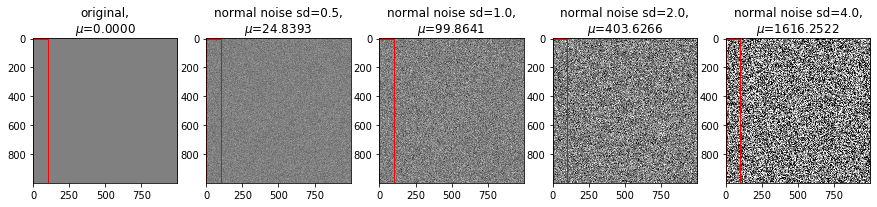

In [2]:
origin_shape = (1000, 1000)
origin = np.zeros(shape=origin_shape)
modifications = [(origin, "original")]
for i in range(1,5):
    mod = origin + np.random.normal(scale=2**i/4, size=origin_shape)
    modifications.append((mod, "normal noise sd={}".format(2**i/4)))
                         
draw_modifications_dist(modifications, vmin=-6, vmax=6, fontsize=12)    

## Assessing on Seismograms with Synthetic Noise

### Loading Data

In [3]:
base_path = '/data/gpn_attention_model_output/'
raw = np.load(base_path+'raw_1.npy')
lift = np.load(base_path+'lift_1.npy')
out = np.load(base_path+'out_1.npy')
att = np.load(base_path+'att_1.npy')

att = 1-att

cv = get_cv([raw])

We will consider a sample seismogram, and 2 denoised versions of it: one using LIFT technique, the other using an ML approach. We also define a mask for ground-roll area. The figre below shows the data

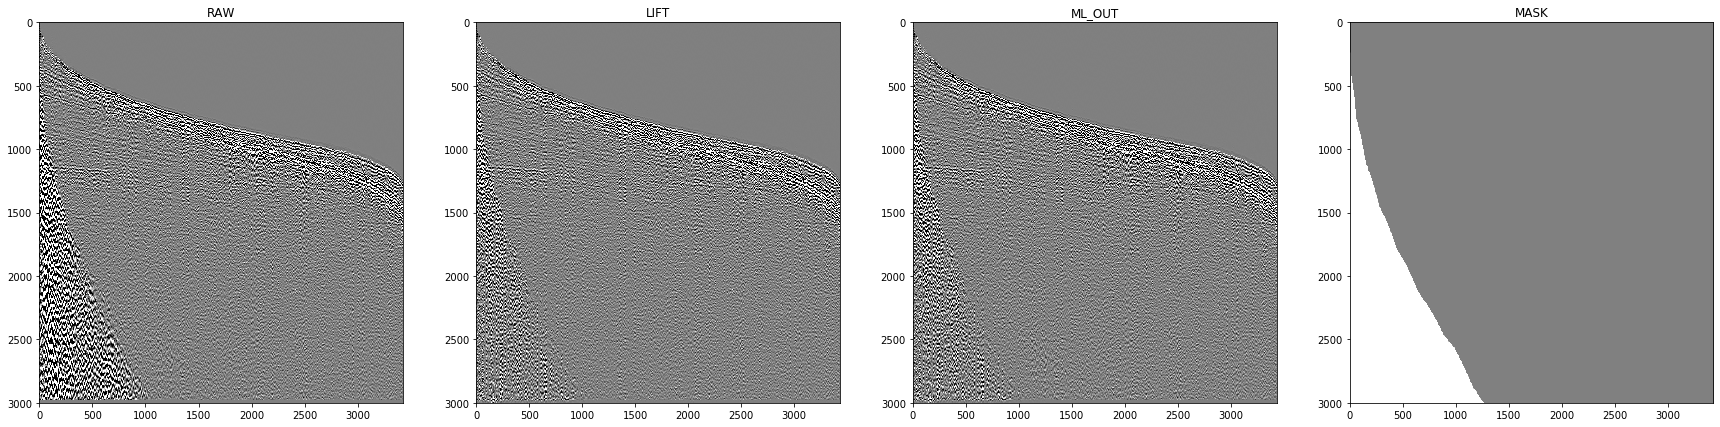

In [4]:
seismic_plot([raw, lift, out, att], figsize=(30, 7), names=['RAW', 'LIFT', 'ML_OUT', 'MASK'], cmap='gray', vmin=-cv, vmax=cv)

To begin with we calculate the differences between raw and LIFT seismograms and between LIFT and ML output

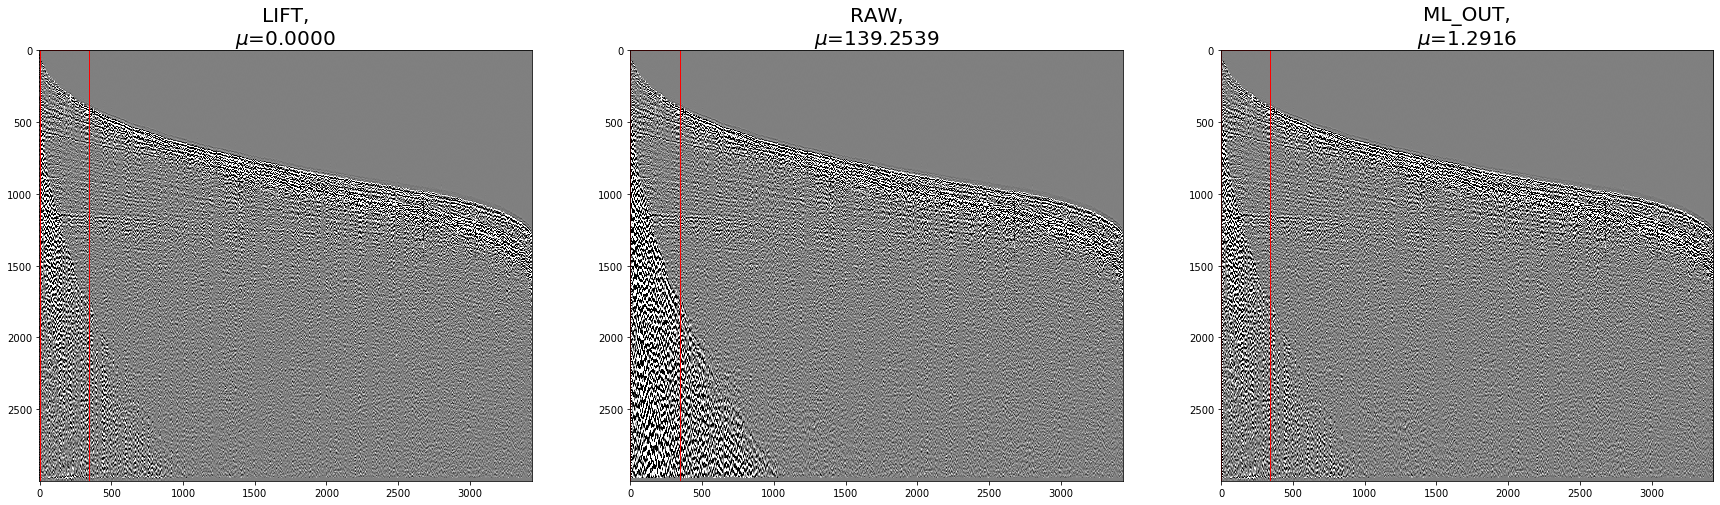

In [5]:
modifications = [(lift, "LIFT"), (raw, "RAW"), (out, "ML_OUT")]

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, figsize=(30, 10))    

Next, we will make several synthetic seismograms by adding noise of different nature to the LIFT and compute difference metric $\mu$ between LIFT and syntetic seismograms

### Noise from difference between raw and lift

We compute the difference between raw and lift and clear all data outside ground roll area.

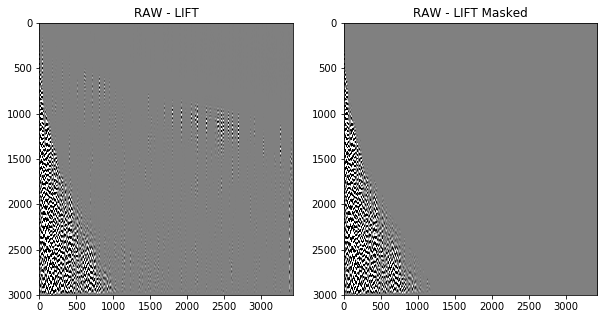

In [6]:
diff = raw - lift
diff_m = diff * att

seismic_plot([diff, diff_m], figsize=(10, 5), names=['RAW - LIFT', 'RAW - LIFT Masked'], cmap='gray', vmin=-cv, vmax=cv)

Next we add this noise multiplyed by increasing coefficient to LIFT and see how the metric changes

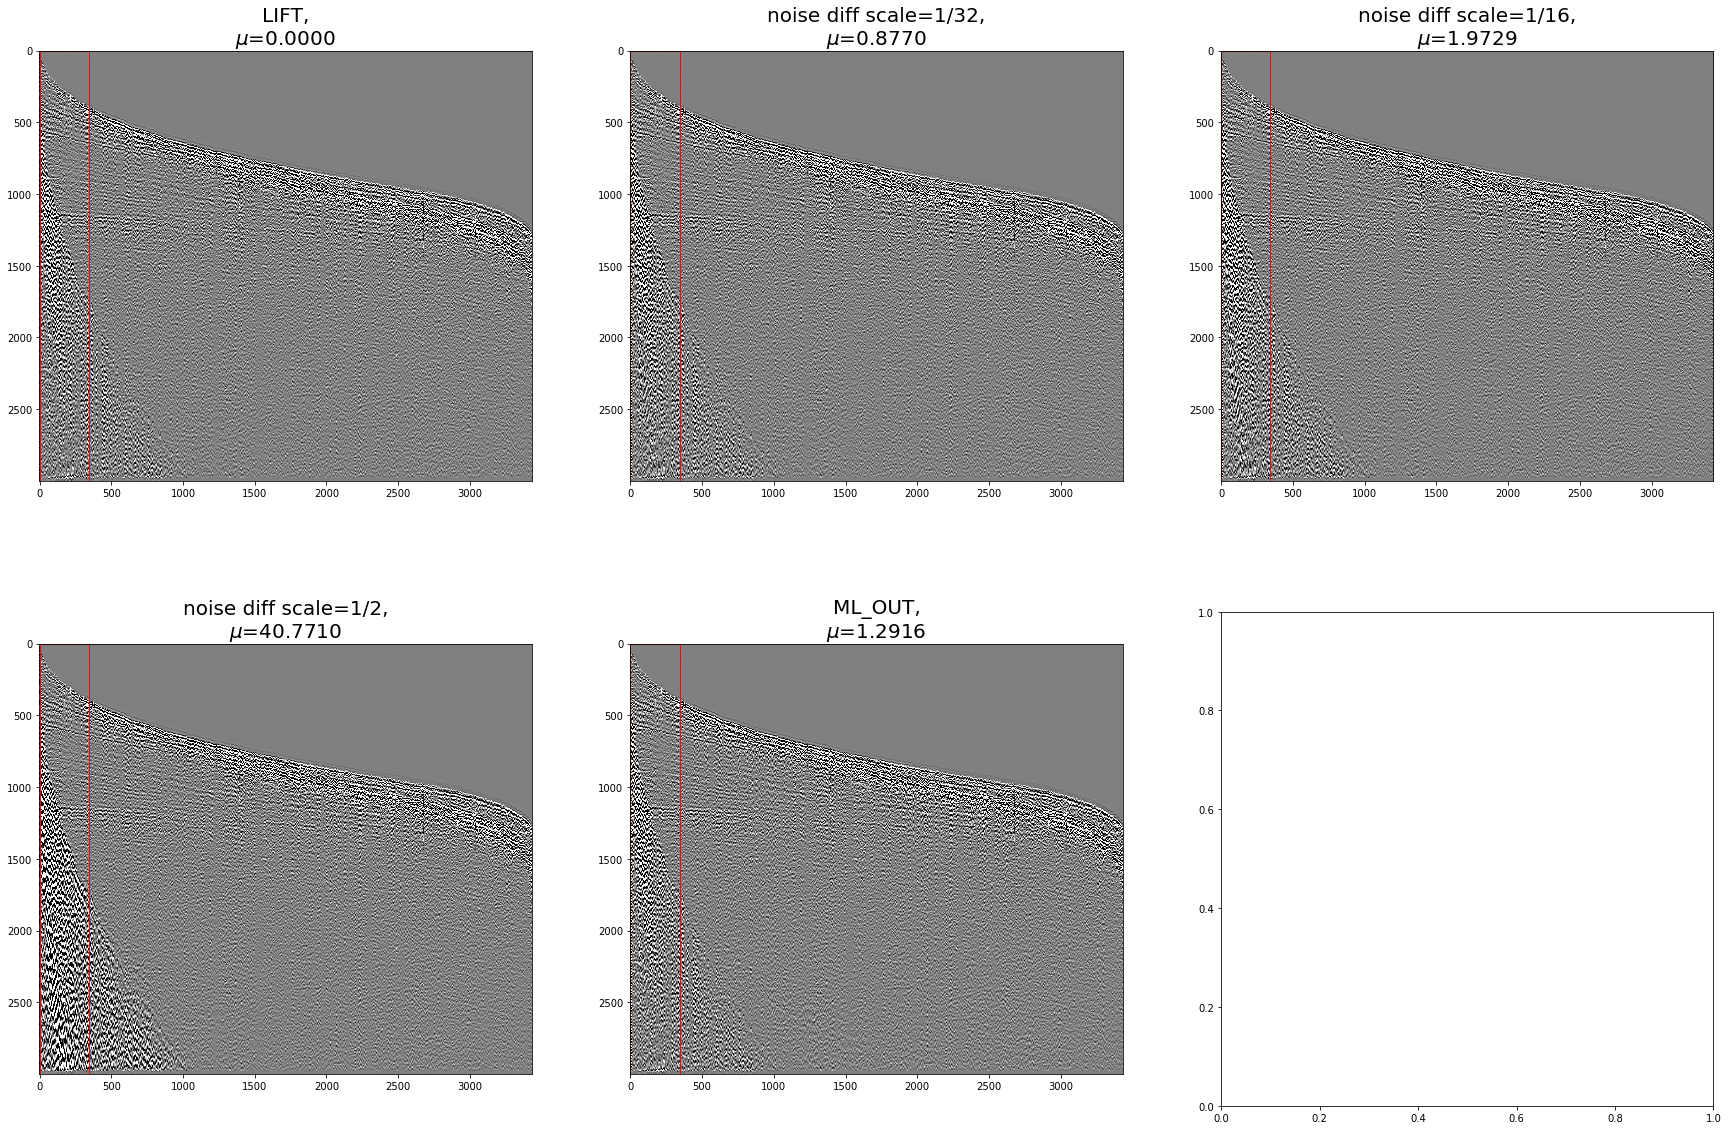

In [7]:
modifications = [(lift, "LIFT")]

for scale in (32, 16, 2):
    mod = lift + diff_m / scale
    modifications.append((mod, "noise diff scale=1/{}".format(scale)))
    
modifications.append((out, "ML_OUT"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, figsize=(30, 20), n_cols=3)    

### Normal noise inside ground roll area

We add normal noise with increasing standard deviation to LIFT inside ground roll area 

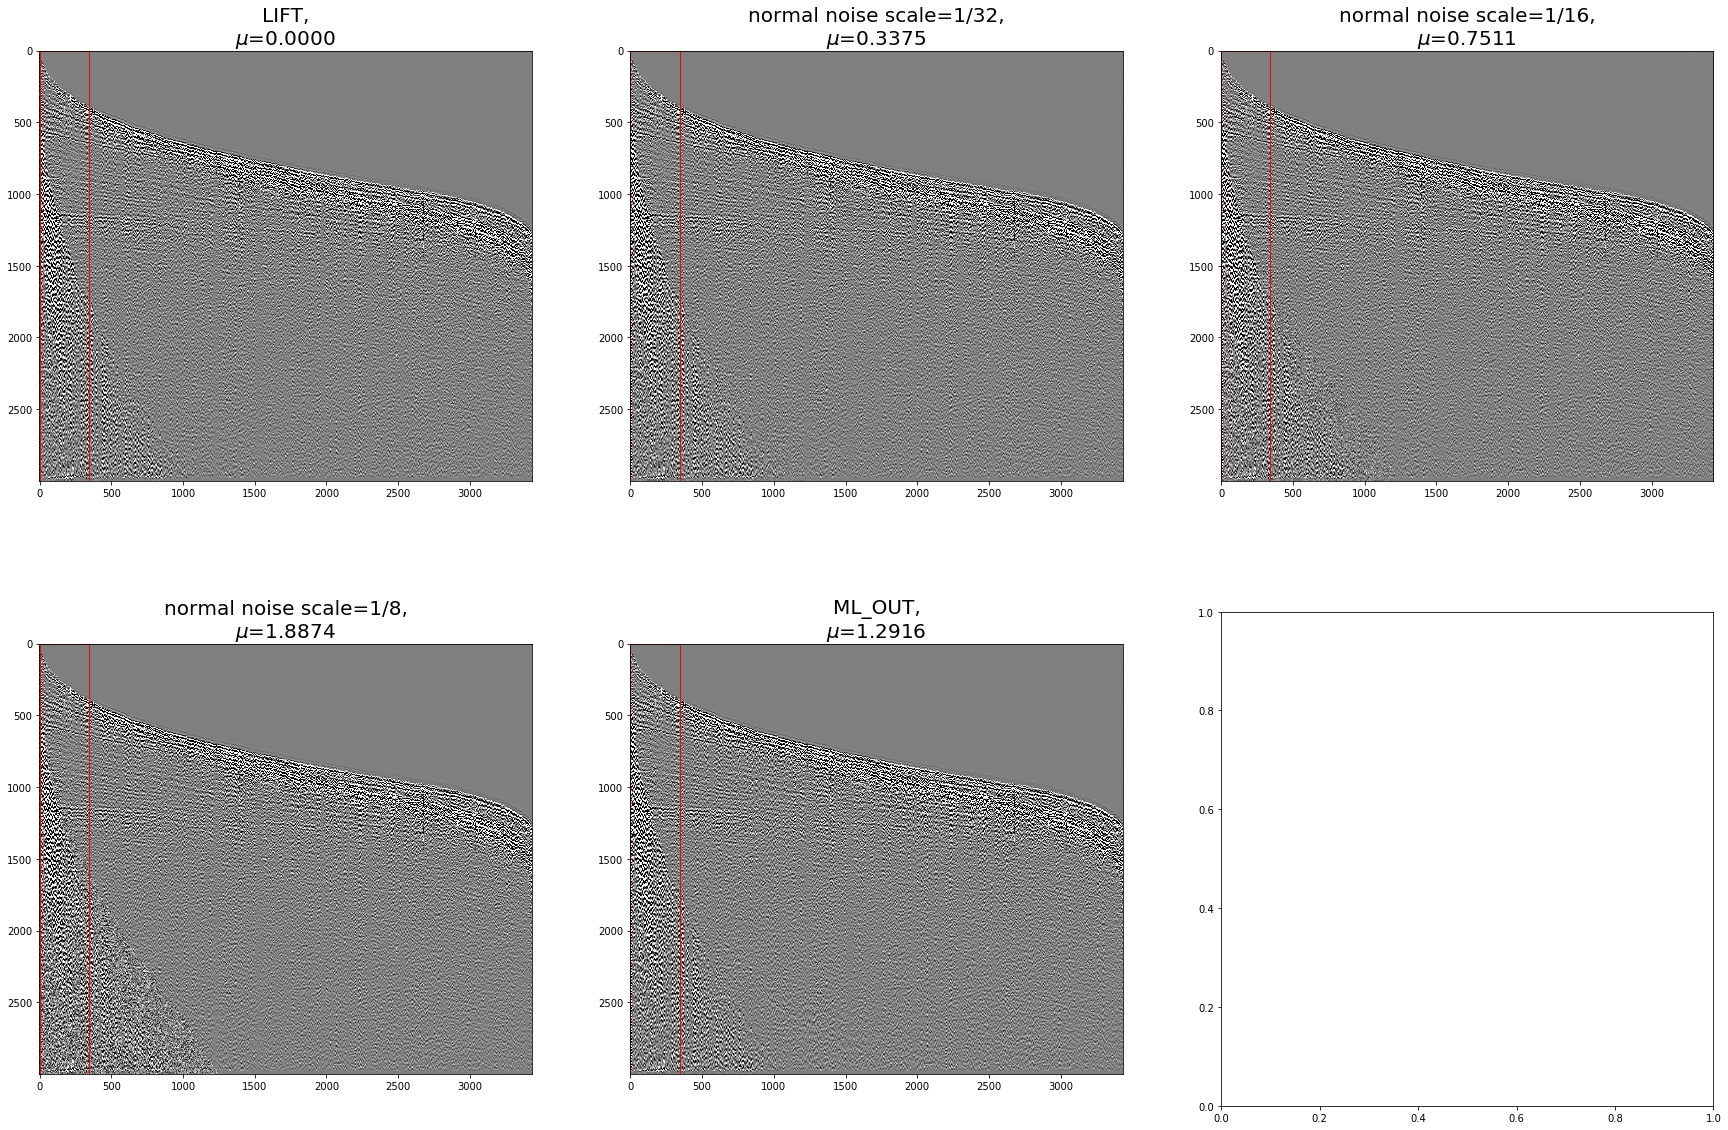

In [8]:
modifications = [(lift, "LIFT")]

for scale in (32, 16, 8):
    mod = lift + np.random.normal(scale=1/scale, size=raw.shape) * att
    modifications.append((mod, "normal noise scale=1/{}".format(scale)))
    
modifications.append((out, "ML_OUT"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, figsize=(30, 20), n_cols=3)    

Examples above show how metric $\mu$ changes when we calculate differences between LIFT and its corrupted variations with noise gradually increasing